## 8. マルコフ連鎖モンテカルロ法(MCMC)法とベイズ統計モデル

In [20]:
import numpy as np
import scipy
from scipy.stats import poisson, binom
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd

In [16]:
data = pd.DataFrame(data=[4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4], columns=['y'])
data['N'] = np.ones(20, dtype=np.int32) * 8

print(len(data))
data.head()

20


,y,N
0,4,8
1,3,8
2,4,8
3,5,8
4,5,8


/home/yoshino/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yoshino/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yoshino/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


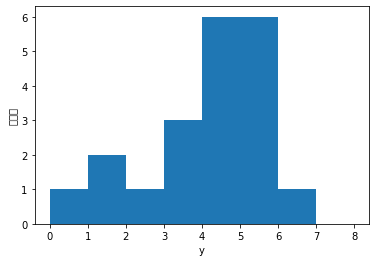

In [17]:
plt.hist(data['y'], bins=range(9))
plt.xlabel('y')
plt.ylabel('種子数')
plt.show()

## 最尤推定による近似

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [18]:
result = smf.glm(formula='y + I(N - y) ~ 1', data=data, family=sm.families.Binomial()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                   20
Model:                            GLM   Df Residuals:                       19
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37.748
Date:                Mon, 23 Jan 2023   Deviance:                       28.722
Time:                        20:32:53   Pearson chi2:                     24.5
No. Iterations:                     3   Pseudo R-squ. (CS):         -1.332e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1754      0.159     -1.105      0.269      -0.487       0.136
==============================================================================
"""

In [19]:
print('最尤推定値: ', 1 / (1 + np.exp(-result.params['Intercept'])))

最尤推定値:  0.4562500000001564


## 8.2 ふらふら試行錯誤による最尤推定

0.6946695785440545

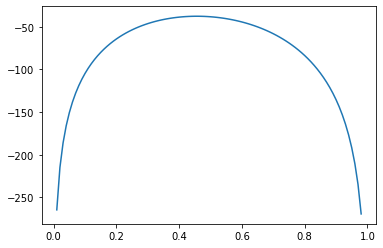

In [37]:
import math
import random

def loglikelihood(data, q):
    ll = 0
    
    for i, r in data.iterrows():
        ll = ll + math.log(scipy.special.comb(r['N'], r['y'])) + r['y']*math.log(q) + (r['N'] - r['y'])*math.log(1 - q)
        
    return ll

qs = np.arange(0.01, 0.99, 0.01)

lls = []
for q in qs:
  ll = loglikelihood(data, q)
  lls.append(ll)

plt.plot(qs, lls)


In [84]:
def hurahura(data, q, n):
  qs = [q]
  
  current_q = q
  current_ll = loglikelihood(data, current_q)
  
  for r in np.random.random(n):
    if r > 0.5:
      q = current_q + 0.001
    else:
      q = current_q - 0.001
    ll = loglikelihood(data, q)

    if ll > current_ll:
      current_ll = ll
      current_q = q
      
    qs.append(q) 

  return qs

hurahura06 = hurahura(data, 0.6, 500)    
hurahura03 = hurahura(data, 0.3, 500)    

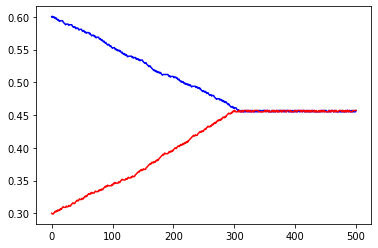

In [85]:
plt.plot(np.arange(len(hurahura06)), hurahura06, label='q start at 0.6', c='b')
plt.plot(np.arange(len(hurahura03)), hurahura03, label='q start at 0.3', c='r')

## MCMC

In [117]:
def mcmc(data, q, n):
  qs = [q]
  
  current_q = q
  current_ll = loglikelihood(data, current_q)
  
  for r1, r2 in zip(np.random.random(n), np.random.random(n)):
    q = current_q + 0.01 if r1 > 0.5 else current_q - 0.01

    if q <= 0.01:
      q = 0.02
    elif q >= 0.99:
      q = 0.98

    ll = loglikelihood(data, q)

    if current_ll < ll or (math.exp(ll - current_ll)  > r2):
      current_ll = ll
      current_q = q
      
    qs.append(q) 

  return qs

mcmc03_100 = mcmc(data, 0.3, 100)
mcmc03_1000 = mcmc(data, 0.3, 1000)
mcmc03_10000 = mcmc(data, 0.3, 10000)

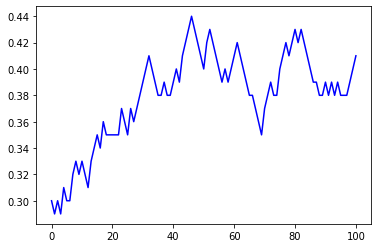

In [118]:
plt.plot(np.arange(len(mcmc03_100)), mcmc03_100, c='b')

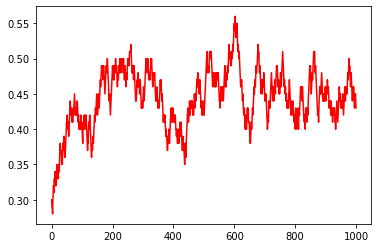

In [119]:
plt.plot(np.arange(len(mcmc03_1000)), mcmc03_1000, c='r')

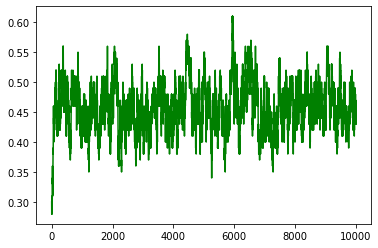

In [121]:
plt.plot(np.arange(len(mcmc03_10000)), mcmc03_10000, c='g')